#### Base Settings

##### 데이터 출처
- [무료 레시피 데이터](https://kadx.co.kr/product/detail/0c5ec800-4fc2-11eb-8b6e-e776ccea3964)



In [ ]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 19.1 MB/s eta 0:00:00


##### Library

In [2]:
# Library import

## pandas
import pandas as pd

import nltk

import numpy as np
import matplotlib.pyplot as plt
import re
import json
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf


import tensorflow_datasets as tfds

import urllib.request

import os
from tqdm import tqdm

from transformers import ElectraTokenizer
from transformers import TFElectraModel

###### Google Drive

In [3]:
# Google drive mout
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
koelectra_model_name = "monologg/koelectra-base-v3-discriminator"

from transformers import ElectraTokenizer
tokenizer = ElectraTokenizer.from_pretrained(koelectra_model_name)

from transformers import TFElectraModel
model = TFElectraModel.from_pretrained(koelectra_model_name, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['electra.embeddings.position_ids', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [ ]:
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data = train_data.reset_index(drop=True)
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
test_data = test_data.reset_index(drop=True)
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

True
False
True
False


In [ ]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)
       
        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        
        # token_type_id는 세그먼트 임베딩을 위한 것으로 이번 예제는 문장이 1개이므로 전부 0으로 통일.
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [ ]:
max_seq_len = 128
train_X, train_y = convert_examples_to_features(train_data['document'], train_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/149995 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 149995/149995 [02:08<00:00, 1169.05it/s]


In [ ]:
test_X, test_y = convert_examples_to_features(test_data['document'], test_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 49997/49997 [00:19<00:00, 2582.26it/s]


In [ ]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
attention_masks_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)

outputs = model([input_ids_layer, attention_masks_layer, token_type_ids_layer])

In [ ]:
class TFElectraForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFElectraForSequenceClassification, self).__init__()
        self.koelectra = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)
        self.classifier = tf.keras.layers.Dense(1,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.koelectra(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

In [ ]:
model.fit(train_X, train_y, epochs=2, batch_size=64, validation_split=0.2)

Epoch 1/2


### Data Preprocessing

#### Read

In [ ]:
def parsing_corpus(json_data):
    title_list = []
    text_list = []

    for idx, doc in enumerate(json_data['document']):

        title = json_data['document'][idx]["paragraph"][0]["form"]
        title_list.append(title)

        text = ""
        for i in range(len(json_data['document'][idx]["paragraph"][1:])):
            text += json_data['document'][idx]["paragraph"][i+1]["form"]+"\n"
        
        text_list.append(text)
    
    title_text_df = pd.DataFrame({"Title" : title_list, "Text" : text_list})

    return title_text_df

In [ ]:
json_read_path = "/content/drive/Shareddrives/my_box/05data/03_table_data/kor_copus/kor_corpus_newspaper_2020/json/NLRW2000000005.json"
with open(json_read_path) as f:
    js = json.loads(f.read())

df = parsing_corpus(js)
df.head()

,Title,Text
0,"현대중공업그룹, 1550억원 규모 원유운반선 2척 수주",현대중공업그룹이 새해 첫 수주에 성공하며 올해 수주 회복세를 이어가고 있다. 원유 ...
1,"[겨울철 피부관리]건조함에 더 고통받는 피부, 속부터 다스려야",30대 직장인 정모씨는 연일 계속되는 건조한 날씨 때문에 피부가 가려웠다. 평소에 ...
2,"울산 양대 사업장, 새해도 노사관계 ‘꽁꽁’",울산지역 양대 사업장인 현대자동차와 현대중공업의 노사관계가 새해 들어서도 각종 난제...
3,"양산시, 주민 반대에도 용선산단 조성 강행",경남 양산시 어곡동 신불산 자락에 추진 중인 용선일반산업단지(이하 용선산단)가 주민...
4,"부산외대, 졸업생 취업역량 강화 위한 ‘One-Stop 취업아카데미’ 운영",부산외국어대학교(총장 정기영)는 오는 28일부터 올해 2월 졸업 예정자들의 취업역량...


In [ ]:
df.columns = ["Q","A"]
train_data = df.copy()

### Model Function

In [ ]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


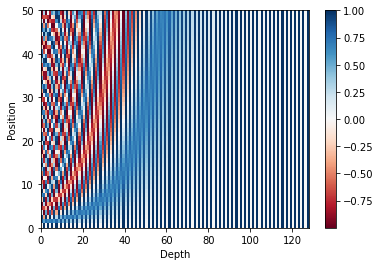

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


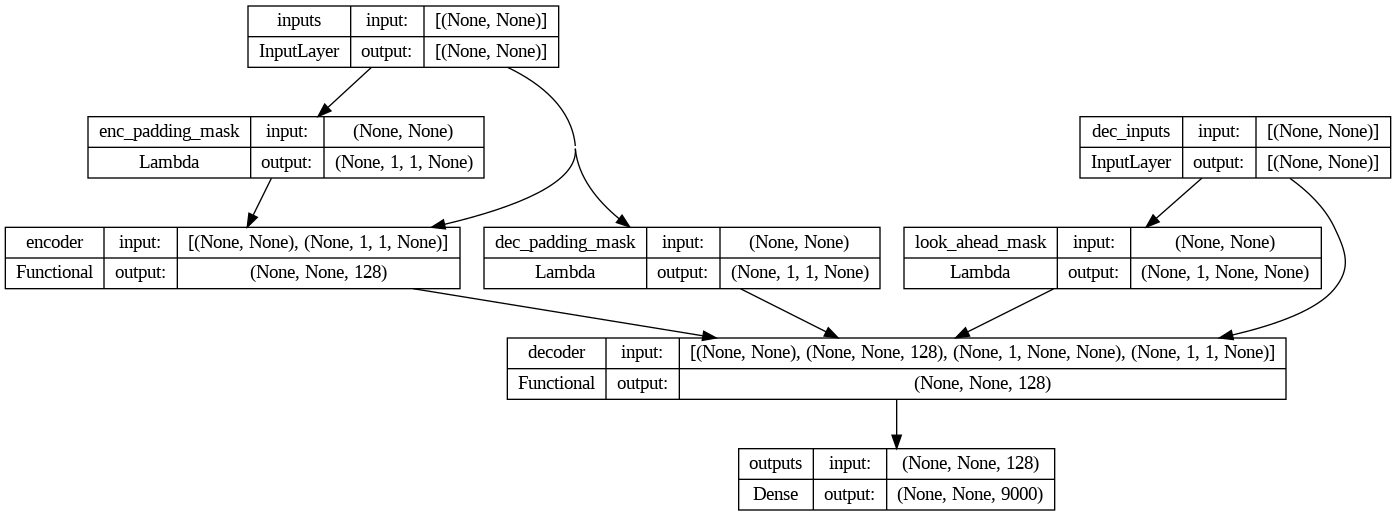

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

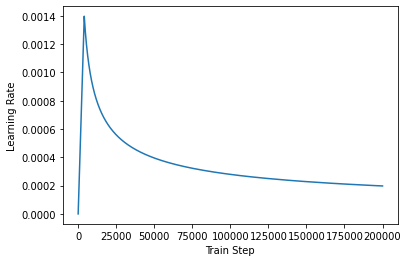

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Chat

In [ ]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 4888


In [ ]:
print(train_data.isnull().sum())

Q    0
A    0
dtype: int64


In [ ]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [ ]:
len(questions)

4888

In [ ]:
print(questions[:5])
print(answers[:5])

['현대중공업그룹 ,  1550억원 규모 원유운반선 2척 수주', '[겨울철 피부관리]건조함에 더 고통받는 피부 ,  속부터 다스려야', '울산 양대 사업장 ,  새해도 노사관계 ‘꽁꽁’', '양산시 ,  주민 반대에도 용선산단 조성 강행', '부산외대 ,  졸업생 취업역량 강화 위한 ‘One-Stop 취업아카데미’ 운영']
['현대중공업그룹이 새해 첫 수주에 성공하며 올해 수주 회복세를 이어가고 있다 .  원유 수송량이 늘면서 올해 선주들의 유조선 발주가 늘어나고 지난해에 이어 올해도 액화천연가스(LNG)운반선 시장도 호황을 이어갈 것으로 보이면서 조선업계의 수주 증대가 기대된다 . \n현대중공업그룹은 최근 유럽지역 선사로부터 1550억원 규모의 15만 8000t급 원유운반선 2척을 수주했다고 20일 밝혔다 . \n이번에 수주한 선박은 길이 274m ,  너비 48m로 ,  영암 현대삼호중공업에서 건조돼 2020년 하반기부터 순차적으로 인도될 계획이다 . \n현대중공업그룹은 올해 조선부문 수주목표를 지난해 대비 21% 높은 159억달러로 잡았다 . \n이는 지난 2014년 이후 가장 높은 수치로 본격적으로 회복세에 접어든 시황을 적극 반영해 수립한 계획이다 . \n실제로 영국 조선 해운·분석기관인 클락슨(Clarkson)은 올해 글로벌 발주량을 지난해(2859만 CGT) 대비 20% 이상 상승한 3440만 CGT로 전망했다 .  글로벌 발주량은 향후 지속적으로 회복세를 유지해 2023년에는 4740만 CGT에 이를 것으로 기대된다 . \n현대중공업그룹 관계자는 "새해부터 선주들의 발주문의가 이어지고 있다"며 ,  "조선 시황이 본격적인 회복세에 접어든 만큼 올해 수주목표 달성을 위해 수주에 역량을 집중할 것"이라고 밝혔다 . \n현대중공업그룹은 지난해 총 163척 ,  140억달러 어치를 수주하며 목표인 132억달러를 초과 달성하는 등 조선업 회복을 주도하고 있다 . \n한편 대우조선해양은 지난 14일 오세아니아 지역 선주로부터 초대형원유운반선(VLCC) 4

In [ ]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8203]
종료 토큰 번호 : [8204]
단어 집합의 크기 : 8205


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5738, 7992, 4849, 424, 1, 8175, 8131, 8120, 8175, 8135, 8076, 7979, 849, 4601, 7979, 319, 388, 7186, 8032]


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5738, 7992, 4849, 424, 1, 8175, 8131, 8120, 8175, 8135, 8076, 7979, 849, 4601, 7979, 319, 388, 7186, 8032]
기존 문장: 울산정보산업진흥원-동서발전 ,  中企 정보보안 기술지원 MOU


In [ ]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5738 ----> 울산정보산업진흥원
7992 ----> -
4849 ----> 동서
424 ----> 발전
1 ---->  ,  
8175 ----> �
8131 ----> �
8120 ----> �
8175 ----> �
8135 ----> �
8076 ----> �
7979 ---->  
849 ----> 정보
4601 ----> 보안
7979 ---->  
319 ----> 기술
388 ----> 지원 
7186 ----> MO
8032 ----> U


In [ ]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (4888, 40)
답변 데이터의 크기(shape) : (4888, 40)


In [ ]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8203 6038    1  511 7189  263 2642 4329 7527 7979 7997 1409 7979 1909
 8204    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[7979 8014 4557 8059 2570 8068 7988 1329 8033 8023 4167 7979 7997 1409
    3 1909   24    4    6 1019  733 1218  194  823 7548   49 3202  141
 1229 7999 3015   48  130  416 7490 2174  107  245   31 8204]


In [ ]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8205
전체 샘플의 수(Number of samples): 4888


In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[7979 8014 4557 8059 2570 8068 7988 1329 8033 8023 4167 7979 7997 1409
    3 1909   24    4    6 1019  733 1218  194  823 7548   49 3202  141
 1229 7999 3015   48  130  416 7490 2174  107  245   31 8204]
[[7979 8014 4557 8059 2570 8068 7988 1329 8033 8023 4167 7979 7997 1409
     3 1909   24    4    6 1019  733 1218  194  823 7548   49 3202  141
  1229 7999 3015   48  130  416 7490 2174  107  245   31]]
[[8014 4557 8059 2570 8068 7988 1329 8033 8023 4167 7979 7997 1409    3
  1909   24    4    6 1019  733 1218  194  823 7548   49 3202  141 1229
  7999 3015   48  130  416 7490 2174  107  245   31 8204]]


In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8205, 256)
(1, 8205, 256)


In [ ]:
MAX_LENGTH = 40

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 5

model.fit(dataset, epochs=EPOCHS)

Epoch 1/5
77/77 [==============================] - 182s 2s/step - loss: 8.9257 - accuracy: 0.0143
Epoch 2/5
77/77 [==============================] - 165s 2s/step - loss: 8.6044 - accuracy: 0.0491
Epoch 3/5
77/77 [==============================] - 165s 2s/step - loss: 8.1629 - accuracy: 0.0645
Epoch 4/5
77/77 [==============================] - 172s 2s/step - loss: 7.6730 - accuracy: 0.0883
Epoch 5/5
77/77 [==============================] - 169s 2s/step - loss: 7.3569 - accuracy: 0.1071


In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
output = predict('이연준, 대통령상 수상')

Input: 이연준, 대통령상 수상
Output:                                  "고 말했다 .


In [ ]:
output = predict('대형산불')

Input: 대형산불
Output:                                  "고 말했다 .


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.5 MB/s eta 0:00:00


In [ ]:
from transformers import TFElectraModel

model = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [ ]:
model.summary()

Model: "tf_electra_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 electra (TFElectraMainLayer  multiple                 112330752 
 )                                                               
                                                                 
Total params: 112,330,752
Trainable params: 112,330,752
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from transformers import ElectraTokenizer
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [ ]:
tokenizer.tokenize("[CLS] 한국어 ELECTRA를 공유합니다. [SEP]")

['[CLS]', '한국어', 'EL', '##EC', '##TRA', '##를', '공유', '##합니다', '.', '[SEP]']

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '한국어', 'EL', '##EC', '##TRA', '##를', '공유', '##합니다', '.', '[SEP]'])

[2, 11229, 29173, 13352, 25541, 4110, 7824, 17788, 18, 3]

In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=ab4390e9e8ca3ea5e1a87b6d4d4444f7c46c928031f318cf6e8e7ceb52f776e7
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers


In [ ]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import urllib.request
from sentence_transformers import SentenceTransformer

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [ ]:
train_data['embedding'] = train_data.apply(lambda row: model.encode(row.Q), axis = 1)

In [ ]:
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
def return_answer(question):
    embedding = model.encode(question)
    train_data['score'] = train_data.apply(lambda x: cos_sim(x['embedding'], embedding), axis=1)
    return train_data.loc[train_data['score'].idxmax()]['A']

In [ ]:
return_answer('너는 누구니?')

'저는 위로봇입니다.'

In [ ]:
return_answer('야구 보러가자')

'재미로 보기 좋죠.'